<a href="https://colab.research.google.com/github/Eliokay/Climate-Project/blob/main/Climate_Analysis_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

Using over 80  years of daily sea surface temperature (SST) data from the South Atlantic ocean basin, the purpose of this project is to examine for evidence of long-term trends such as warming ocean temperatures and more frequent or intense storms. ERA5 is produced by the European Center for Medium-Range Weather Forecasting (ECMWF), widely regarded as the best forecasting center in the world.

# Import libraries

In [1]:
!pip install pmdarima
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='whitegrid')
from scipy.signal import welch
from scipy.signal import butter, filtfilt
import pmdarima as pm
from prophet import Prophet

# Load clean data

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/Eliokay/Climate-Project/main/south_atlantic.csv")
df

,sst,u10,hsig,time,latitude,longitude
0,295.14398,-2.858145,1.880945,1940-01-01 12:00:00,-30.1,-16.1
1,295.19820,-10.065320,2.357849,1940-01-02 12:00:00,-30.1,-16.1
2,295.24457,-4.187378,1.975307,1940-01-03 12:00:00,-30.1,-16.1
3,295.29690,5.083636,1.438365,1940-01-04 12:00:00,-30.1,-16.1
4,295.34857,-4.042992,1.379800,1940-01-05 12:00:00,-30.1,-16.1
...,...,...,...,...,...,...
30741,297.68597,-9.494390,2.753758,2024-03-01 12:00:00,-30.1,-16.1
30742,297.77972,-12.307160,2.996628,2024-03-02 12:00:00,-30.1,-16.1
30743,297.50876,7.454432,3.386987,2024-03-03 12:00:00,-30.1,-16.1
30744,297.50876,11.993222,4.631128,2024-03-04 12:00:00,-30.1,-16.1


# State your question





Are there discernible trends in the dataset, and if so, can they be projected into the future?

# Analysis

In [3]:
sst = df["sst"].values
n = len(sst)  # Total length
t = np.arange(n)  # Daily data
dt = t[1] - t[0]  # Sampling interval dt = 1 day
fs = 1 / dt  # Sampling frequency fs = 1 sample/day (often abbreviated cpd for cycles per day)
f0 = (1 / n) / dt  # Frequency resolution
p = int((n - 1) / 2)

In [4]:
p

15372

##Power Spectral Density

Using the Welch's method to interrogate the signal's frequency content

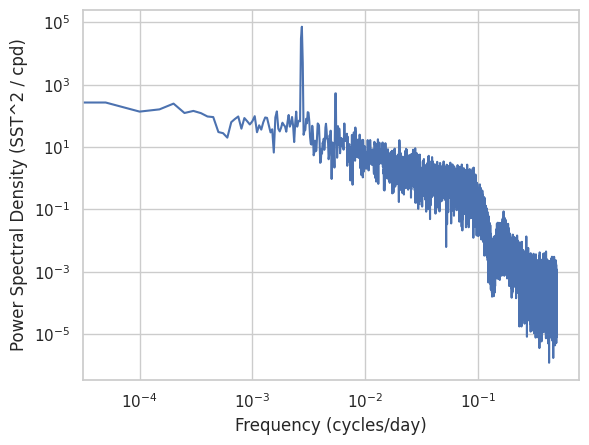

In [5]:
f, Pw = welch(sst, fs=1.0, window="hamming", nperseg=20000)
fig, ax = plt.subplots()
ax.plot(f, Pw)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Frequency (cycles/day)")
ax.set_ylabel("Power Spectral Density (SST^2 / cpd)")
plt.show()

This code will help us find the signal's frequency responsible for the greatest peak by identifying the peak rquency range.

In [6]:
f_range = (f > 1e-3) & (f < 1e-2)
df_sorted = pd.DataFrame(columns=["f", "P"])
df_sorted["f"] = f[f_range]
df_sorted["P"] = Pw[f_range]

In [7]:
df_sorted.sort_values(by="P", ascending= False)

,f,P
34,0.00275,72062.469267
33,0.00270,29858.942311
35,0.00280,5200.142377
89,0.00550,527.656420
88,0.00545,524.223576
...,...,...
164,0.00925,1.268847
170,0.00955,1.062022
80,0.00505,0.945669
127,0.00740,0.851687


To identify the period of the signal

In [8]:
1/0.00275

363.6363636363637

From this, we can tell that this increase in SST is an annual occurence that is probably due to the earth revolvng around the sun.

##Filtering using Buterworth Lowpass

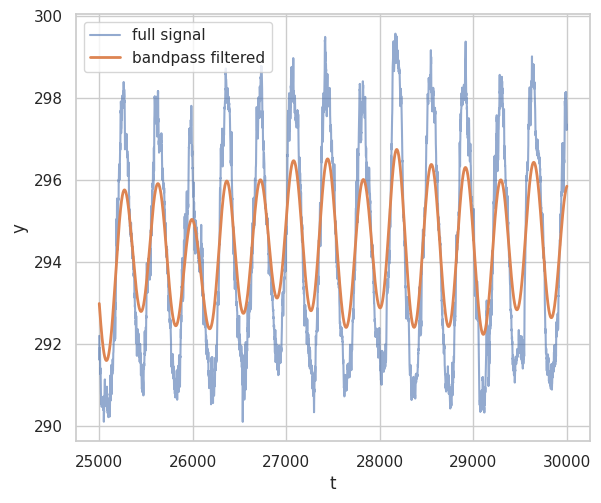

In [9]:
fc = 0.002760
fs = 1.0
Wn = fc / (fs / 2)
N = 2
b, a = butter(N, Wn, btype="lowpass")
yfilt_band = filtfilt(b, a, sst)

mask = list(range(25000, 30000))
fig, ax = plt.subplots()
ax.plot(t[mask], sst[mask], alpha=0.6, label="full signal")
ax.plot(t[mask], yfilt_band[mask], linewidth=2, label="bandpass filtered")
ax.set_xlabel("t")
ax.set_ylabel("y")
ax.legend()
fig.set_size_inches(6, 5)
fig.tight_layout(pad=0.5)

The filtered signal seems to remain constan- between 290 ad 298K, across time.

In [10]:
#adding the filtered signal to the daaset
df['sst_filt'] = yfilt_band

##Creating a Regrssion Model to forcast the SST

###Train/test Split

In [11]:
train_indices = list(range(len(df) // 2))
test_indices = list(range(len(df) // 2, len(df)))

df_train = df.loc[train_indices, :]
df_test = df.loc[test_indices, :]

# Setting up the dataset for the Prophet
df_train = pd.DataFrame({"ds": pd.to_datetime(df_train["time"]), "y": df_train["sst"]})
df_test = pd.DataFrame({"ds": pd.to_datetime(df_test["time"]), "y": df_test["sst"]})


In [12]:
yfilt_band

array([295.41143961, 295.41616034, 295.420777  , ..., 295.41693215,
       295.41759413, 295.4181382 ])

##Forcasting the filtered signal

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfi7wj3nc/9x7trx9y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfi7wj3nc/_np5m9e0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73241', 'data', 'file=/tmp/tmpfi7wj3nc/9x7trx9y.json', 'init=/tmp/tmpfi7wj3nc/_np5m9e0.json', 'output', 'file=/tmp/tmpfi7wj3nc/prophet_model0aqhws1y/prophet_model-20240520224530.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:45:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:45:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


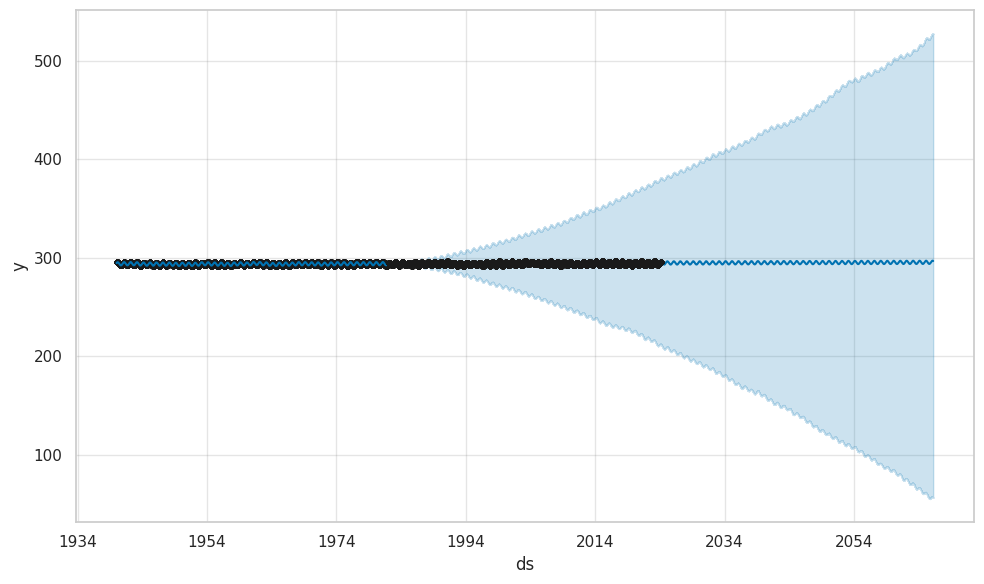

In [13]:
df_train_filt = df_train.copy()
df_train_filt["y"] = yfilt_band[:len(df_train)]

df_test_filt = df_test.copy()
df_test_filt["y"] = yfilt_band[len(df_train):]

#fitting the model
model_filt = Prophet()
model_filt.fit(df_train_filt)

future_filt = model_filt.make_future_dataframe(periods=2*len(df_test_filt), freq="1D")
forecast_filt = model_filt.predict(future_filt)
fig1 = model_filt.plot(forecast_filt)
ax = fig1.gca()
ax.plot(df_test_filt["ds"], df_test_filt["y"], 'ko', markersize=3)

This forcast shows that the SST will be quite constant as the years go by.

In [14]:
df['time'] = pd.to_datetime(df['time'])

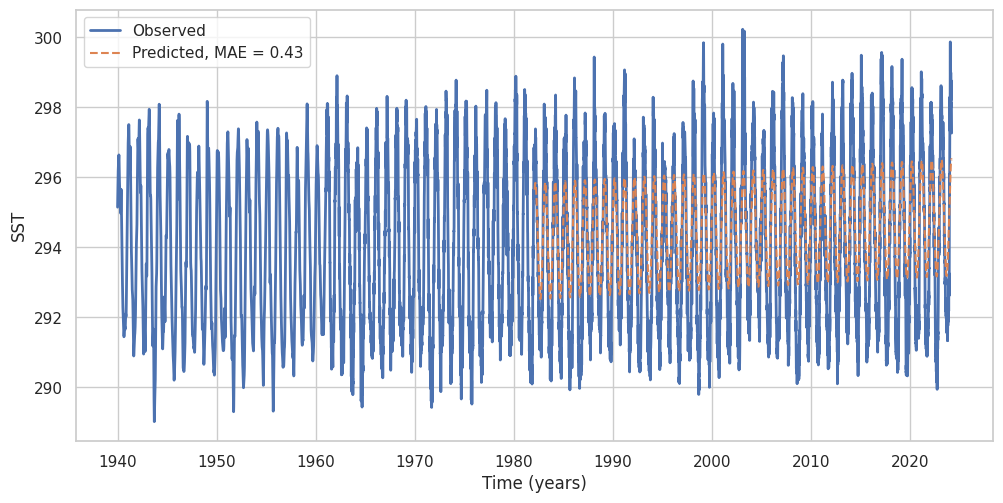

In [15]:
mae_filt = np.nanmean(np.abs(forecast_filt.loc[test_indices, "yhat"] - df_test_filt['y'].squeeze()))
fig, ax = plt.subplots()
ax.plot(df['time'], df['sst'], '-', linewidth=2, label="Observed")
ax.plot(df['time'][test_indices], forecast_filt.loc[test_indices, "yhat"], '--', label=f"Predicted, MAE = {mae_filt:.2f}")
ax.legend()
ax.set_xlabel("Time (years)")
ax.set_ylabel("SST")
fig.set_size_inches(10, 5)
fig.tight_layout(pad=0.5)
plt.show()

##Additional Analysis

Conducting a comparative analysis by creating a second model using the SST signal from the entire dataset **to** evaluate how predictions using the SST differed from those based solely on the filtered SST signal.


In [16]:
# Fitting the second model
model = Prophet()
model.fit(df_train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfi7wj3nc/zr86pprn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfi7wj3nc/kihizx6h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62026', 'data', 'file=/tmp/tmpfi7wj3nc/zr86pprn.json', 'init=/tmp/tmpfi7wj3nc/kihizx6h.json', 'output', 'file=/tmp/tmpfi7wj3nc/prophet_modeletlu86ab/prophet_model-20240520224559.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:45:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:46:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


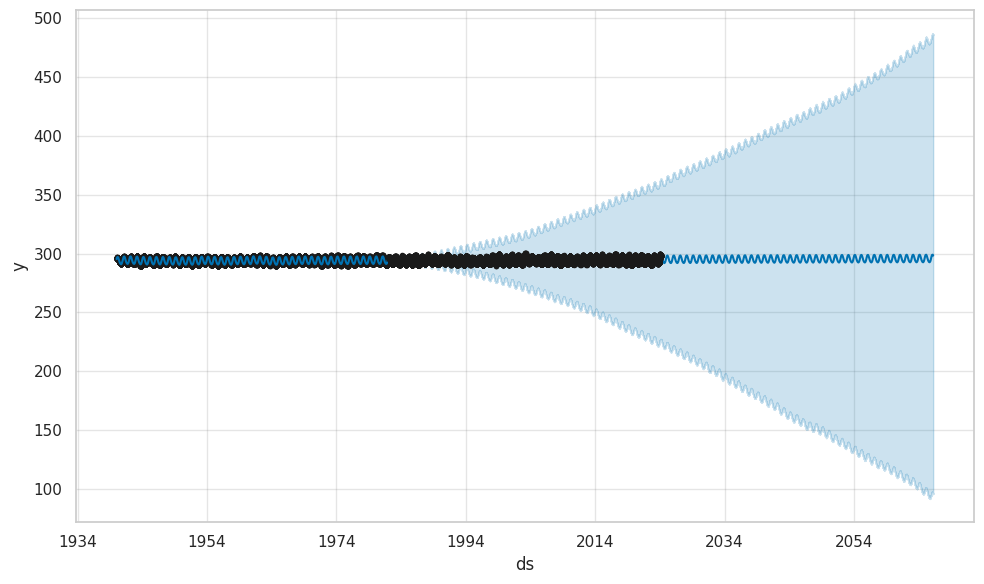

In [17]:
#forcasting the second model
future = model.make_future_dataframe(periods=2*len(df_test), freq="1D")
forecast = model.predict(future)
fig1 = model.plot(forecast)
ax = fig1.gca()
ax.plot(df_test["ds"], df_test["y"], 'ko', markersize=3)

In [18]:
df['time'] = pd.to_datetime(df['time'])

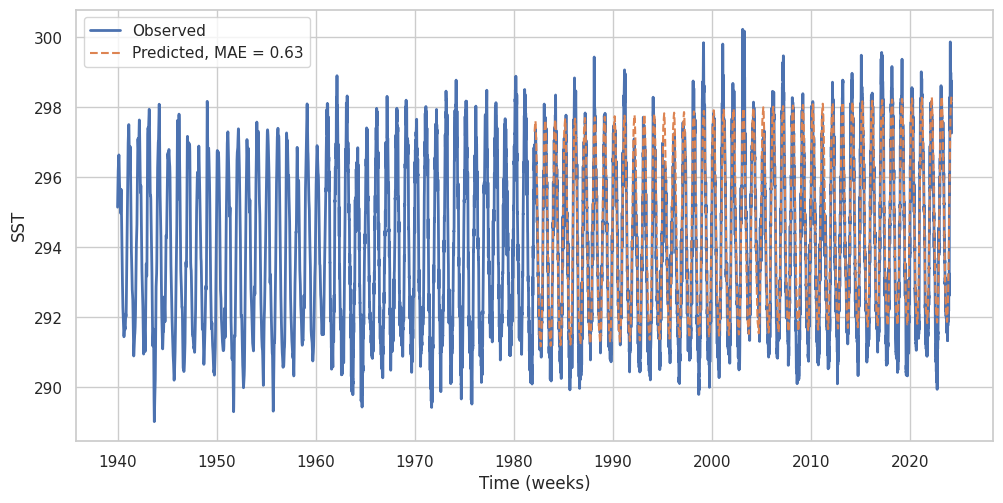

In [20]:
mae = np.nanmean(np.abs(forecast.loc[test_indices, "yhat"] - df_test['y'].squeeze()))
fig, ax = plt.subplots()
ax.plot(df['time'], df['sst'], '-', linewidth=2, label="Observed")
ax.plot(df['time'][test_indices], forecast.loc[test_indices, "yhat"], '--', label=f"Predicted, MAE = {mae:.2f}")
ax.legend()
ax.set_xlabel("Time (weeks)")
ax.set_ylabel("SST")
fig.set_size_inches(10, 5)
fig.tight_layout(pad=0.5)
plt.show()

## Conclusion

From the graphs we see that the SST shows a trend of slight increase in temperatures with time. This is most probably due to global warming.

From the additional analysis, the model with the filtered signal was better at forcasting the SST into the future. The model with the unfiltered SST values had a MAE of 0.63 while the model with the filtered SST had an MAE of 0.43. This shows the importance of filtering and smoothening signals before building predictive models.